# DSCI 100 Group Project

>## Authors: Derek, Eric, and Selina

### Introduction

...

In [ ]:
set.seed(1)
library(dplyr)
library(readxl)
library(tidyverse)

heart_disease_data <- read_csv("data/heart_disease.data", col_names = FALSE, na = c("?")) |>
    setNames(c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")) |>
    mutate(cp = as_factor(cp))
heart_disease_data

In [29]:
library(tidymodels)

heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = cp)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split) 

In [6]:
glimpse(heart_disease_train)

Rows: 150
Columns: 14
$ age      <dbl> 66, 60, 63, 63, 74, 55, 55, 61, 59, 42, 55, 63, 60, 62, 56, 5…
$ sex      <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ cp       <fct> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 2, 1, 1, 3…
$ trestbps <dbl> 110, 120, NA, 130, NA, NA, 0, 120, NA, 134, 120, NA, NA, NA, …
$ chol     <dbl> 213, 0, 0, 0, 0, 228, 0, 0, 0, 240, 0, 0, 316, 0, 0, 0, 0, 21…
$ fbs      <dbl> 1, NA, 0, 0, 0, 0, 0, 0, 0, NA, 0, 0, 1, 0, 0, 1, NA, 1, 0, 0…
$ restecg  <dbl> 2, 0, 2, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 1, 1, 0, 1, 0…
$ thalach  <dbl> 99, 141, NA, 111, NA, NA, 155, 80, 128, 160, 125, NA, NA, NA,…
$ exang    <dbl> 1, 1, NA, 1, NA, NA, 0, 1, 1, 0, 1, NA, NA, NA, 1, 1, 0, 0, N…
$ oldpeak  <dbl> 1.3, 2.0, NA, 0.0, NA, NA, 1.5, 0.0, 2.0, 0.0, 2.5, NA, NA, N…
$ slope    <dbl> 2, 1, NA, NA, NA, NA, 2, 2, 3, NA, 2, NA, NA, NA, NA, 2, 3, N…
$ ca       <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ thal     <dbl> N

In [7]:
glimpse(heart_disease_test)

Rows: 50
Columns: 14
$ age      <dbl> 63, 44, 60, 66, 60, 52, 69, 56, 52, 64, 60, 59, 56, 67, 72, 7…
$ sex      <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ cp       <fct> 4, 4, 4, 3, 3, 3, 4, 4, 3, 4, 4, 4, 2, 1, 3, 4, 4, 4, 4, 4, 4…
$ trestbps <dbl> 140, 130, 132, 120, 180, 128, 130, 120, 122, 144, NA, 122, 12…
$ chol     <dbl> 260, 209, 218, 0, 0, 0, 0, 100, 0, 0, 281, 233, 224, 270, 214…
$ fbs      <dbl> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0…
$ restecg  <dbl> 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0…
$ thalach  <dbl> 112, 127, 140, 120, 140, 180, 129, 120, 110, 122, NA, 117, 16…
$ exang    <dbl> 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, NA, 1, 0, 0, 1, 0, 1, 1, 1, NA,…
$ oldpeak  <dbl> 3.0, 0.0, 1.5, -0.5, 1.5, 3.0, 1.0, 1.5, 2.0, 1.0, NA, 1.3, 2…
$ slope    <dbl> 2, NA, 3, 1, 2, 1, 2, 2, 3, 2, NA, 3, 2, 1, 2, NA, 2, 3, NA, …
$ ca       <dbl> NA, NA, NA, NA, NA, NA, NA, 0, NA, NA, NA, NA, NA, NA, NA, NA…
$ thal     <dbl> NA

In [12]:
heart_disease_observations <- heart_disease_train |>
                      group_by(cp) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(heart_disease_train))
heart_disease_observations

cp,n,percent
<fct>,<int>,<dbl>
1,6,4.000000
2,10,6.666667
3,36,24.000000
4,98,65.333333


List of 1
 $ text:List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 12
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

Warning message:
“Removed 43 rows containing missing values (geom_point).”


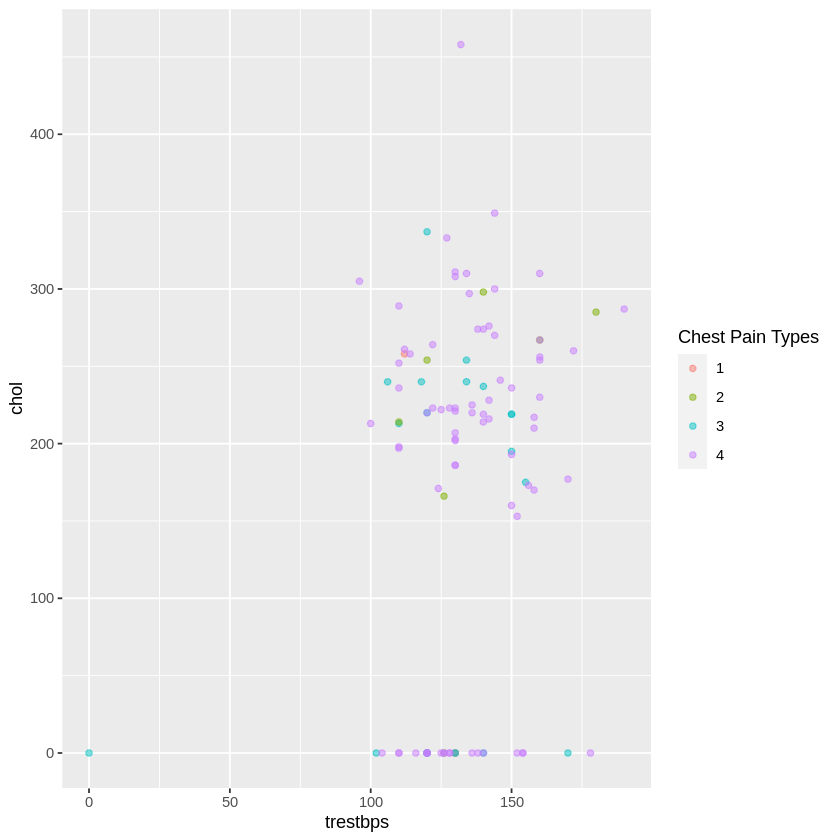

In [28]:
set.seed(1)
trestbps_chol <- heart_disease_train |>
  ggplot(aes(x = trestbps, y = chol, color = cp)) +
  geom_point(alpha = 0.5) +
  labs(color = "Chest Pain Types") 
  #scale_color_manual(labels = c("1", "2","3","4"), 
                     #values = c("orange2", "steelblue2","orange2", "steelblue2")) + 
  theme(text = element_text(size = 12))

trestbps_chol